### Create alongshore half gaussian pulse wind stress file for a region in the domain
* Winds blowing only in a specific rectangular region of the domain
* Find meridional and zonal contirbutions to get alongshore wind stress pulse, spatially uniform.
* Generate zonal and meridional binary files for upwelling and downwelling favourable alongshore windstress (4 files).
* Gaussian pulse, e-fold of value `sigma`, max windstress of `max_tau`, centered in time around `center`

In [1]:
import cmocean as cmo
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

### INPUT

Only change these values

In [12]:
## Gaussian pulse
nt = 120 # number of wind records
end_time = 60 # end time of records
t = np.linspace(0,end_time,nt) # time array of wind records
max_tau = 0.1 # original 0.1
sigma = 1 
center = 4.5#base 3.5 hr, faster 2.5 hr, slower 4.5
gauss = max_tau*np.exp(-((t-center)**2)/(2*sigma))
mask = t>center
gauss[mask]=0

## Rotation angle (in deg) to get alongshore winds (see previous notebook)
angle_up = 120. # upwelling favourable
angle_down = 300. # downwelling favourable

## Grid size
nx = 512 
ny = 612 
lat_bot = 27.0 
lat_top = 35.3 

## Region where winds will blow (over SVB: 27.9, 30.0, -115.1, -114)
lat1 = 27.0 
lat2 = 35.3 
lon1 = -122
lon2 = -114

## Domain boundaries
lon_ini = -122.0
lon_end = -114.0
lat_ini = 27.0
lat_end = 35.3

# filenames - 4 files created: 2 upw (zonal and meridional components), 2 downwelling (zonal and merid)
run_desc = 'halfgauss_slower' # descriptive string to add to wind filename. 
                     # Final name is eg. upwelling_merid_gauss1d_160x224.bin saved in dir 160x224/

### Make files

This is your half gaussian pulse
4.006529739295107e-06


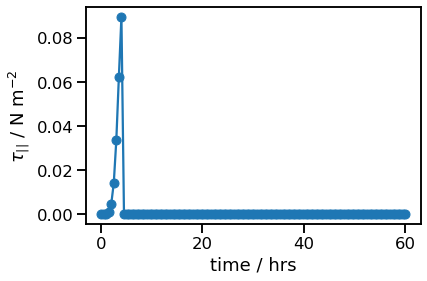

In [13]:
plt.plot(t,gauss,'-o')
plt.xlabel('time / hrs')
plt.ylabel(r'$\tau_{||}$ / N m$^{-2}$')
print('This is your half gaussian pulse')
print(gauss[0])

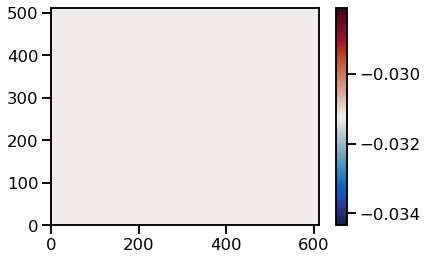

In [14]:
### Rotate winds
windstress= np.expand_dims(np.expand_dims(gauss,0),0) + np.zeros((nx,ny,nt))

alpha = np.radians(120.)
alpha2 = np.radians(300.)

zonal_tau = windstress*np.cos(alpha)
merid_tau = windstress*np.sin(alpha)

zonal_tau2 = windstress*np.cos(alpha2)
merid_tau2 = windstress*np.sin(alpha2)

cm = plt.pcolormesh(zonal_tau[:,:,7], cmap=cmo.cm.balance)
plt.colorbar(cm)

In [15]:
### Set windstress to 0 outside region of interest
lon = np.linspace(lon_ini, lon_end, nx)
lat = np.linspace(lat_ini, lat_end, ny)

LAT,LON = np.meshgrid(lat,lon)
lon_array = np.expand_dims(LON,2) + np.zeros((nx,ny,nt))
lat_array = np.expand_dims(LAT,2) + np.zeros((nx,ny,nt))

mask_lon = lon_array<lon1
mask_lat = lat_array>lat2 
mask_lat2 = lat_array<lat1

In [16]:
def apply_mask(array):
    array[mask_lon] = 0 
    array[mask_lat] = 0 
    array[mask_lat2] = 0 
    return(array)

In [17]:
zonal_tau = apply_mask(zonal_tau)
merid_tau = apply_mask(merid_tau)
zonal_tau2 = apply_mask(zonal_tau2)
merid_tau2 = apply_mask(merid_tau2)

<ipython-input-18-3b83f3fcdd7a>:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pc = plt.pcolormesh(lat,lon,zonal_tau[:,:,5])


(512, 612, 120)


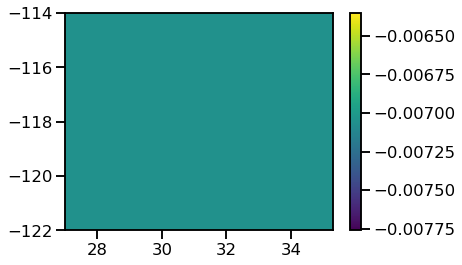

In [18]:
pc = plt.pcolormesh(lat,lon,zonal_tau[:,:,5])
plt.colorbar(pc)
print(np.shape(zonal_tau))

In [19]:
### Write binary files
dt = np.dtype('>f8')  # float 64 big endian

wind_fname1 = '%dx%d/downwelling_merid_%s_%dx%d.bin' %(nx,ny,run_desc,nx,ny)
fileobj = open(wind_fname1, mode='wb')
dd=merid_tau.transpose((2,1,0))
dd.astype(dt).tofile(fileobj,"")
fileobj.close()

wind_fname2 = '%dx%d/downwelling_zonal_%s_%dx%d.bin' %(nx,ny,run_desc,nx,ny)
fileobj = open(wind_fname2, mode='wb')
dd=zonal_tau.transpose((2,1,0))
dd.astype(dt).tofile(fileobj,"")
fileobj.close()

wind_fname3 = '%dx%d/upwelling_zonal_%s_%dx%d.bin' %(nx,ny,run_desc,nx,ny)
fileobj = open(wind_fname3, mode='wb')
dd=zonal_tau2.transpose((2,1,0))
dd.astype(dt).tofile(fileobj,"")
fileobj.close()

wind_fname4 = '%dx%d/upwelling_merid_%s_%dx%d.bin' %(nx,ny,run_desc,nx,ny)
fileobj = open(wind_fname4, mode='wb')
dd=merid_tau2.transpose((2,1,0))
dd.astype(dt).tofile(fileobj,"")
fileobj.close()

#### Check that bin file works when read by fortran

(37601280,)


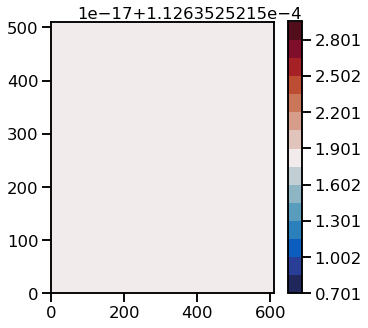

In [20]:
cc=np.fromfile(wind_fname3, dtype=dt)
print(np.shape(cc))

bF=np.reshape(cc,[nx,ny,nt],'F') # F to read in Fortran order

fig,ax = plt.subplots(1,1, figsize=(5,5))

pc = ax.contourf(bF[:,:,2], 20, cmap=cmo.cm.balance)
plt.colorbar(pc,ax=ax)

(0.0, 20.0)

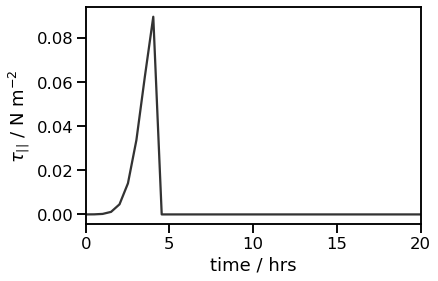

In [21]:
# Make a plot for talks
import seaborn as sns

sns.set_context('talk')
plt.plot(t,gauss,'-', color='0.2')
plt.xlabel('time / hrs')
plt.ylabel(r'$\tau_{||}$ / N m$^{-2}$')
plt.xlim(0,20)